# Alrawiyah الرّاوية 
Arabic Poetry Recommender (The Testing Code)

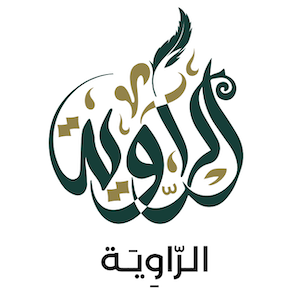

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sat May 28 07:49:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

#### 1. Download the required files 

In [2]:
# Download the weights
import os

!gdown https://drive.google.com/uc?id=1-5kKs4YK3VUUW7m_vgNvnw_HrRGqcoUe&export=download
!gdown https://drive.google.com/uc?id=1ynr0SvAMjWyZI3mETDGkeAG6WzTW_UR9&export=download
!gdown https://drive.google.com/uc?id=1v4JGpdUazc-OzFiapWnKDf0sB3P3dAbg&export=download

os.chdir('/content/')  
!unzip -u test_images.zip -d test_images/  



Downloading...
From: https://drive.google.com/uc?id=1-5kKs4YK3VUUW7m_vgNvnw_HrRGqcoUe
To: /content/Poems_model_50_epochs.pt
100% 709M/709M [00:02<00:00, 244MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ynr0SvAMjWyZI3mETDGkeAG6WzTW_UR9
To: /content/test_images.zip
100% 1.01M/1.01M [00:00<00:00, 152MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v4JGpdUazc-OzFiapWnKDf0sB3P3dAbg
To: /content/metrec_dataset_clean.csv
100% 7.70M/7.70M [00:00<00:00, 44.6MB/s]
Archive:  test_images.zip
  inflating: test_images/test_images/birds.jpg  
  inflating: test_images/test_images/flower.jpg  
  inflating: test_images/test_images/sunset.jpg  
  inflating: test_images/test_images/sea_sky.jpg  
  inflating: test_images/test_images/door.jpg  
  inflating: test_images/test_images/makkah.jpg  
  inflating: test_images/test_images/moon.jpg  


In [3]:
# Download the poem embedding
#!gdown https://drive.google.com/uc?id=1-5kKs4YK3VUUW7m_vgNvnw_HrRGqcoUe&export=download

#### 2. Get the model and embeddings

In [4]:
!pip install ftfy sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.0 MB/s 
     |████████████████████████████████| 79 kB 6.3 MB/s 
     |████████████████████████████████| 4.2 MB 56.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.2 MB/s 
     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=00da59ee347bc84726a8c8c241217df20323b56319b541b74087434464e3d89b
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!git clone https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.91 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [6]:
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

from sentence_transformers import util

import torch.nn as nn
import numpy as np

from CLIP import clip

In [7]:
class CLIP_Net(nn.Module):
    def __init__(self, features_image=1280,features_text=768,projection_dim=256,normalize=1):
        super(CLIP_Net, self).__init__()

        self.backbone,  self.preprocessor = clip.load('ViT-B/32', device,jit=True)
        self.Dense=nn.Linear(768,512).to(device)

        self.logit_scale = nn.Parameter(torch.ones([]))

    def forward(self,x_im,x_tx):
    
        image_features, text_features = self.backbone(x_im, x_tx)
        

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        logit_scale = self.logit_scale.exp()
        logits_per_iamge = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_iamge, logits_per_text

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
Poems_model = CLIP_Net().to(device)


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.6MiB/s]


In [9]:
import pandas as pd
import gc
df_metrec = pd.read_csv('/content/metrec_dataset_clean.csv');

metrec_text = clip.tokenize(df_metrec['text_clean'].iloc[10000:20000].to_list()).to(device)
with torch.no_grad():
    text_features = Poems_model.backbone.encode_text(metrec_text)
    torch.cuda.empty_cache()
    gc.collect()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:607.)
  import sys


In [10]:
#torch.save(text_features, 'poems_emb_metrec_10000.pt')

In [11]:
checkpoint = torch.load("/content/Poems_model_50_epochs.pt")


In [12]:
checkpoint["input_resolution"] = 224 # Poems_model.backbone.input_resolution #default is 224
checkpoint["context_length"] = 77 # Poems_model.backbone.context_length # default is 77
checkpoint["vocab_size"] = Poems_model.backbone.vocab_size 

In [13]:
# checkpoint['model_state_dict']["input_resolution"] = 224 # Poems_model.backbone.input_resolution #default is 224
# checkpoint['model_state_dict']["context_length"] = 77 # Poems_model.backbone.context_length # default is 77
# checkpoint['model_state_dict']["vocab_size"] = Poems_model.backbone.vocab_size 

In [14]:
res = {str(key).replace("backbone.",""): val for key, val in checkpoint['model_state_dict'].items()}


In [15]:
Poems_model.backbone.load_state_dict(res,strict=False)


_IncompatibleKeys(missing_keys=['input_resolution', 'context_length', 'vocab_size'], unexpected_keys=['Dense.weight', 'Dense.bias'])

In [16]:
#poems_emb_metrec = torch.load('/content/poems_emb_metrec_10000.pt')

#### 3. Test the model

In [17]:
image_name = "sunset"
image = Poems_model.preprocessor(Image.open("/content/test_images/test_images/" + image_name  + ".jpg")).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = Poems_model.backbone.encode_image(image)

hits = util.semantic_search(image_features, text_features, top_k=5)[0]

for hit in hits:
        print(df_metrec['text'].iloc[hit['corpus_id']], hit['score'])


كم بيمناه قصة قد أجيبت   وسؤول بها أجيب سؤاله 0.2060546875
أيد مني وقال أي دم   أرقت فهو الجبار والهدر 0.20068359375
فقلت إن الإمام آثرها   بصيب من يمينه انهملا 0.19091796875
وخليل الله همت قومه   أن يكيدوه فكانوا الأخسرينا 0.1900634765625
وكان لي قلب فلما زارني   وهبته لحسنه استبشارا 0.1885986328125


## 1. Retriving text given the image (Twitter + Unsplash dataset) 

In [18]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))